In [65]:
import tensorflow as tf

# Vérifier si les GPU sont détectés
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs détectés : {len(gpus)}")
else:
    print("Aucun GPU détecté")


Aucun GPU détecté


In [56]:
import numpy as np
import os
import sys
sys.path.append('../')
import cv2
from utils import load_datasets
from copy import deepcopy
import sklearn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from keras.api.models import Model
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout, GlobalAveragePooling2D
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy, categorical_crossentropy
from keras.api.utils import to_categorical
import random
import matplotlib.style
import seaborn as sns
from keras.applications import ResNet50

In [8]:
def load_train_val(datasets_dir, multi_class=True, new_shape=(270, 460), read_from_stubs=False, stub_path=None, save_stub=False, shuffle=False):
    
    if read_from_stubs and stub_path is not None and len(os.listdir(stub_path)) > 0:
        with open(os.path.join(stub_path, 'ds01_train.npy'), 'rb') as f:
            ds01_train = np.load(f)
        with open(os.path.join(stub_path, 'ds01_val.npy'), 'rb') as f:
            ds01_val = np.load(f)
        with open(os.path.join(stub_path, 'y01_train.npy'), 'rb') as f:
            y01_train = np.load(f)
        with open(os.path.join(stub_path, 'y01_val.npy'), 'rb') as f:
            y01_val = np.load(f)
        
        return ds01_train, y01_train, ds01_val, y01_val 
    
    folders = os.listdir(datasets_dir) if multi_class else os.listdir(datasets_dir)[:4]

    train_total_size = 0
    for folder in folders:
        if folder.endswith('01'):
            train_total_size  += len(os.listdir(os.path.join(datasets_dir, folder)))
    
    ds01_train = np.empty(shape=(int(0.8*train_total_size), new_shape[0], new_shape[1], 3), dtype=np.float32)
    ds01_val = np.empty(shape=(int(0.2*train_total_size), new_shape[0], new_shape[1], 3), dtype=np.float32)
    y01_train = np.empty(shape=(int(0.8*train_total_size), 1))
    y01_val = np.empty(shape=(int(0.2*train_total_size), 1))
    idx_01_train = 0
    idx_01_val = 0
    y01_train_class = 0
    y01_val_class = 0
    
    for folder in folders:
        len_folder = len(os.listdir(os.path.join(datasets_dir, folder)))  
        
        images_path = os.listdir(os.path.join(datasets_dir, folder))
        random.shuffle(images_path)
        if folder.endswith('01'):
            
            for i, file in enumerate(images_path[:int(0.8*len_folder)]):
                ds01_train[i+idx_01_train] = cv2.resize(cv2.imread(os.path.join(datasets_dir, folder, file)) / 255.0, new_shape[::-1])
                y01_train[i+idx_01_train] = y01_train_class
            idx_01_train += int(0.8*len_folder)
            y01_train_class += 1
            
            for i, file in enumerate(images_path[int(0.8*len_folder):]):
                ds01_val[i+idx_01_val] = cv2.resize(cv2.imread(os.path.join(datasets_dir, folder, file)) / 255.0, new_shape[::-1])
                y01_val[i+idx_01_val] = y01_val_class
            idx_01_val += int(0.2*len_folder)
            y01_val_class += 1
    
    if multi_class:
        y01_train = to_categorical(y01_train)
        y01_val = to_categorical(y01_val)
        
    if save_stub:
        with open(os.path.join(stub_path, 'ds01_train.npy'), 'wb') as f:
            np.save(f, ds01_train)
        with open(os.path.join(stub_path, 'ds01_val.npy'), 'wb') as f:
            np.save(f, ds01_val)
        with open(os.path.join(stub_path, 'y01_train.npy'), 'wb') as f:
            np.save(f, y01_train)
        with open(os.path.join(stub_path, 'y01_val.npy'), 'wb') as f:
            np.save(f, y01_val)
    
        
    if not shuffle:
        return (ds01_train, y01_train), (ds01_val, y01_val)
    else:
        return sklearn.utils.shuffle(ds01_train, y01_train), sklearn.utils.shuffle(ds01_val, y01_val)
    

In [9]:
def load_test(datasets_dir, multi_class=True, new_shape=(270, 460), read_from_stubs=False, stub_path=None, save_stub=False, shuffle=False):
    
    if read_from_stubs and stub_path is not None and len(os.listdir(stub_path)) > 0:
        with open(os.path.join(stub_path, 'ds02.npy'), 'rb') as f:
            ds02 = np.load(f)
        with open(os.path.join(stub_path, 'y02.npy'), 'rb') as f:
            y02 = np.load(f)
        return(ds02, y02)
    
    folders = os.listdir(datasets_dir) if multi_class else os.listdir(datasets_dir)[:4]
    test_total_size = 0
    for folder in folders:
        if folder.endswith('02'):
            test_total_size  += len(os.listdir(os.path.join(datasets_dir, folder)))
    
    ds02 = np.empty(shape=(test_total_size, new_shape[0], new_shape[1], 3), dtype=np.float32)
    y02 = np.empty(shape=(test_total_size, 1))
    
    idx_val = 0
    y02_val_class = 0
    for folder in folders:
        len_folder = len(os.listdir(os.path.join(datasets_dir, folder)))
        if folder.endswith('02'):
            for file in os.listdir(os.path.join(datasets_dir, folder)):
                ds02[idx_val] = cv2.resize(cv2.imread(os.path.join(datasets_dir, folder, file)) / 255.0, new_shape[::-1])
                y02[idx_val] = y02_val_class
                idx_val += 1
            y02_val_class += 1
    
    if multi_class:
        y02 = to_categorical(y02)
    
    if save_stub:
        with open(os.path.join(stub_path, 'ds02.npy'), 'wb') as f:
            np.save(f, ds02)
        with open(os.path.join(stub_path, 'y02.npy'), 'wb') as f:
            np.save(f, y02)

    if not shuffle:
        return (ds02, y02)
    else:
        return sklearn.utils.shuffle(ds02, y02)

In [23]:
def visualize_data_sample(x, y, random=False):
    if random:
        ind = np.random.permutation(x.shape[0])
        plt.figure(figsize=(20,6))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(x[ind[i], :, :, ::-1]), plt.title(f'class : {str(y[ind[i]])}, ind : {ind[i]}'), plt.axis('off')
    else:
        plt.figure(figsize=(20,6))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(x[i, :, :, ::-1]), plt.title(f'class : {str(y[i])}, ind : {i}'), plt.axis('off')

In [11]:
MULTI_CLASS = True
SHUFFLE = True

In [12]:
(x_train, y_train), (x_val, y_val) = load_train_val(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

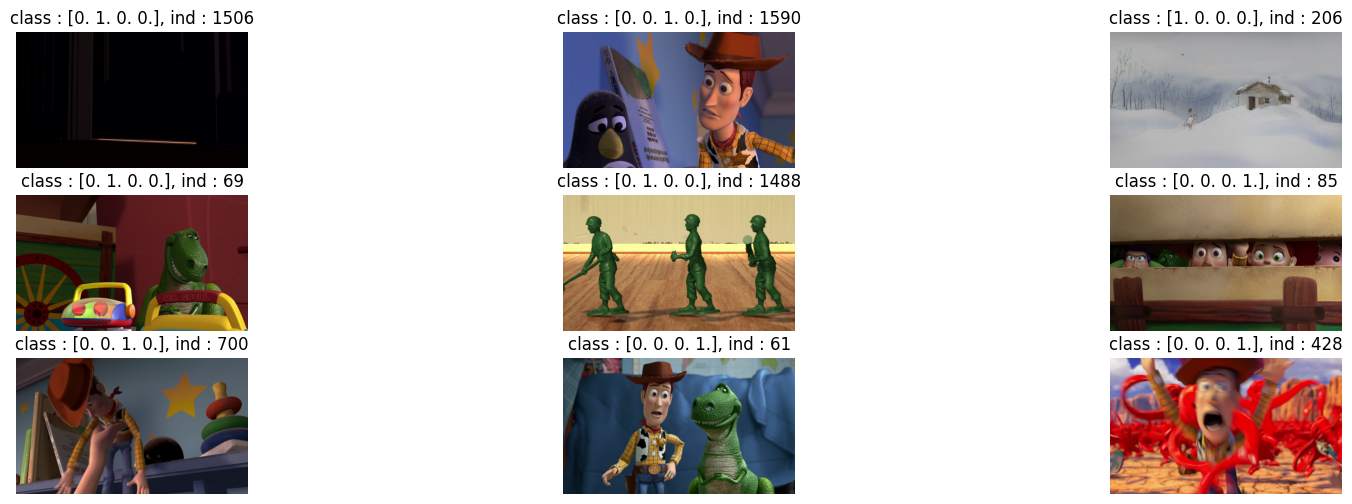

In [25]:
visualize_data_sample(x=x_train, y=y_train, random=True)

In [26]:
(x_test, y_test) = load_test(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

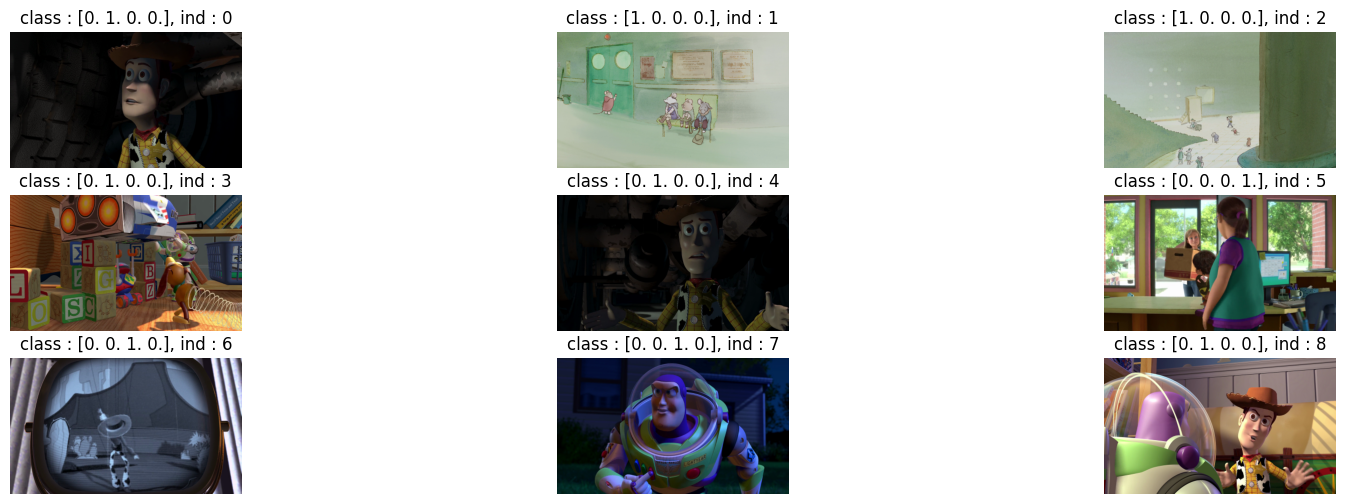

In [27]:
visualize_data_sample(x=x_test, y=y_test)

In [29]:
input = Input((270, 460, 3))

x = Conv2D(filters=16, kernel_size=3, strides=1)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)

x = Dense(4)(x)
output = Activation('softmax')(x)

model_mult = Model(input, output)

In [30]:
model_mult.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 270, 460, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 268, 458, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 268, 458, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 268, 458, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 134, 229, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 66, 114, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 66, 114, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 66, 114, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 33, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 60192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,704,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,711,012 (29.42 MB)

 Trainable params: 7,710,660 (29.41 MB)

 Non-trainable params: 352 (1.38 KB)

In [32]:
opt = Adam(learning_rate=0.0005)
model_mult.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

In [33]:
history = model_mult.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 436ms/step - accuracy: 0.5124 - loss: 1.4130 - val_accuracy: 0.2500 - val_loss: 2.8258
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.8012 - loss: 0.5459 - val_accuracy: 0.2500 - val_loss: 2.7994
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 428ms/step - accuracy: 0.9051 - loss: 0.2889 - val_accuracy: 0.2550 - val_loss: 2.0675
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 438ms/step - accuracy: 0.9503 - loss: 0.1838 - val_accuracy: 0.4475 - val_loss: 1.3590
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.9643 - loss: 0.1126 - val_accuracy: 0.6475 - val_loss: 0.9176
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 449ms/step - accuracy: 0.9603 - loss: 0.1234 - val_accuracy: 0.7600 - val_loss: 0.6497
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.9737 - loss: 0.0936 - val_accuracy: 0.7975 - val_loss: 0.5554
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - accuracy: 0.9775 - loss: 0

In [34]:
evaluation = model_mult.evaluate(x=x_test, y=y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.4811 - loss: 2.5463


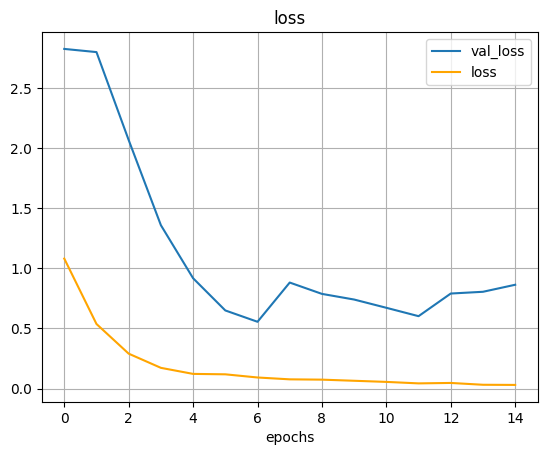

In [35]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('loss')
plt.grid(True)

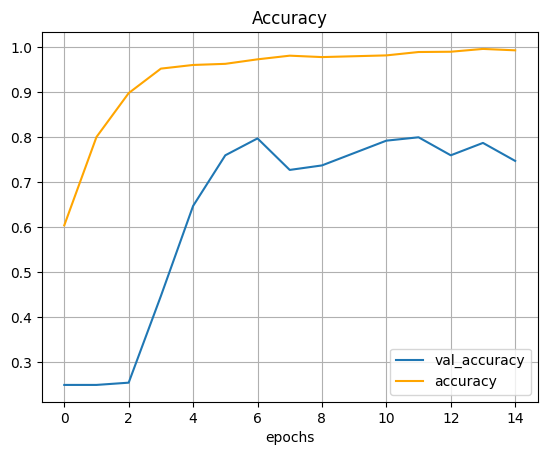

In [36]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('Accuracy')
plt.grid(True)

In [37]:
y_pred = model_mult.predict(x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step


In [42]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1, 2, 3])

Text(50.722222222222214, 0.5, 'True classes')

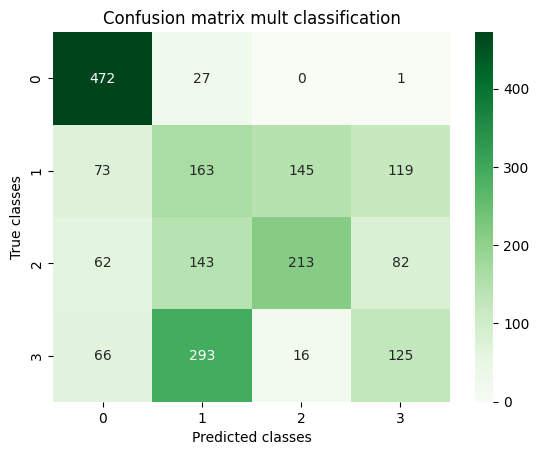

In [44]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens'), plt.title('Confusion matrix mult classification')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')

In [48]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(270, 460, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [52]:
for layer in base_model.layers:
    layer.trainable = False

In [57]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(4)(x)
output = Activation('softmax')(x)

model_resnet = Model(base_model.input, output)
opt = Adam(learning_rate=0.0005)
model_resnet.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

In [58]:
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 270, 460,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 276, 466,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 135, 230,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 135, 230,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 135, 230,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 137, 232,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 68, 115,   │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 68, 115,   │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 68, 115,   │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 68, 115,   │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 68, 115,   │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 68, 115,   │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 68, 115,   │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 68, 115,   │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 68, 115,   │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 68, 115,   │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 68, 115,   │      1,024 │ conv2_block1_3_c

 Total params: 23,851,012 (90.98 MB)

 Trainable params: 263,044 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [59]:
history_resnet = model_resnet.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4689 - loss: 1.3136 - val_accuracy: 0.2625 - val_loss: 1.6179
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5879 - loss: 0.9733 - val_accuracy: 0.2525 - val_loss: 1.7619
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.6261 - loss: 0.8961 - val_accuracy: 0.2525 - val_loss: 2.4540
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.6390 - loss: 0.8472 - val_accuracy: 0.4175 - val_loss: 2.0072
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6844 - loss: 0.7811 - val_accuracy: 0.2575 - val_loss: 2.1647
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6922 - loss: 0.7372 - val_accuracy: 0.2525 - val_loss: 5.9804
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.7159 - loss: 0.7050 - val_accuracy: 0.2525 - val_loss: 10.4526
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7531 - loss: 0.6562 - val_acc

KeyboardInterrupt: 